In [1]:
import os
import pyciemss
import pandas as pd
import numpy as np

import pyciemss.visuals.plots as plots

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

import importlib

smoke_test = ('CI' in os.environ)

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type2_petrinet.json")
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
dataset2 = os.path.join(DATA_PATH, "traditional.csv")

In [3]:
start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_samples = 3 if smoke_test else 100

In [4]:
data_mapping = {"case": "infected", "hosp": "hospitalized"} # data is mapped to observables
# data_mapping = {"case": "I", "hosp": "H"} # data is mapped to state variables

num_iterations = 10 if smoke_test else 1000
calibrated_results = pyciemss.calibrate(model1, dataset1, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
calibrated_results

/Users/cott741/projects/ASKEM/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 2 rows of data. The first column, Timestamp, begins at 1.1 and ends at 3.3. The subsequent columns are named: case, hosp


{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 27.085692018270493}

In [5]:
parameter_estimates()

{'persistent_beta_c': tensor(0.3743, grad_fn=<ExpandBackward0>),
 'persistent_kappa': tensor(0.6312, grad_fn=<ExpandBackward0>),
 'persistent_gamma': tensor(0.3627, grad_fn=<ExpandBackward0>),
 'persistent_hosp': tensor(0.1505, grad_fn=<ExpandBackward0>),
 'persistent_death_hosp': tensor(0.0438, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(8.2040, grad_fn=<ExpandBackward0>)}

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,persistent_beta_s_param,...,S_state,I_state,E_state,R_state,H_state,D_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,0.0,0.154147,0.358388,0.353817,0.145714,0.075675,7.854665,1.0,...,19339992.0,7.854665,40.000000,0.000000,0.000000,0.000000,7.854665,40.000000,0.000000,0.000000
1,1,0,10.0,0.154147,0.358388,0.353817,0.145714,0.075675,7.854665,1.0,...,19339928.0,20.062355,28.612480,58.877068,4.248661,0.378738,20.062355,28.612480,4.248661,0.378738
2,2,0,20.0,0.154147,0.358388,0.353817,0.145714,0.075675,7.854665,1.0,...,19339858.0,20.472496,29.128653,129.032013,5.108327,1.104756,20.472496,29.128653,5.108327,1.104756
3,3,0,30.0,0.154147,0.358388,0.353817,0.145714,0.075675,7.854665,1.0,...,19339780.0,20.862137,29.682844,201.160614,5.311420,1.895700,20.862137,29.682844,5.311420,1.895700
4,4,0,40.0,0.154147,0.358388,0.353817,0.145714,0.075675,7.854665,1.0,...,19339702.0,21.259037,30.247480,274.746094,5.426815,2.708618,21.259037,30.247480,5.426815,2.708618


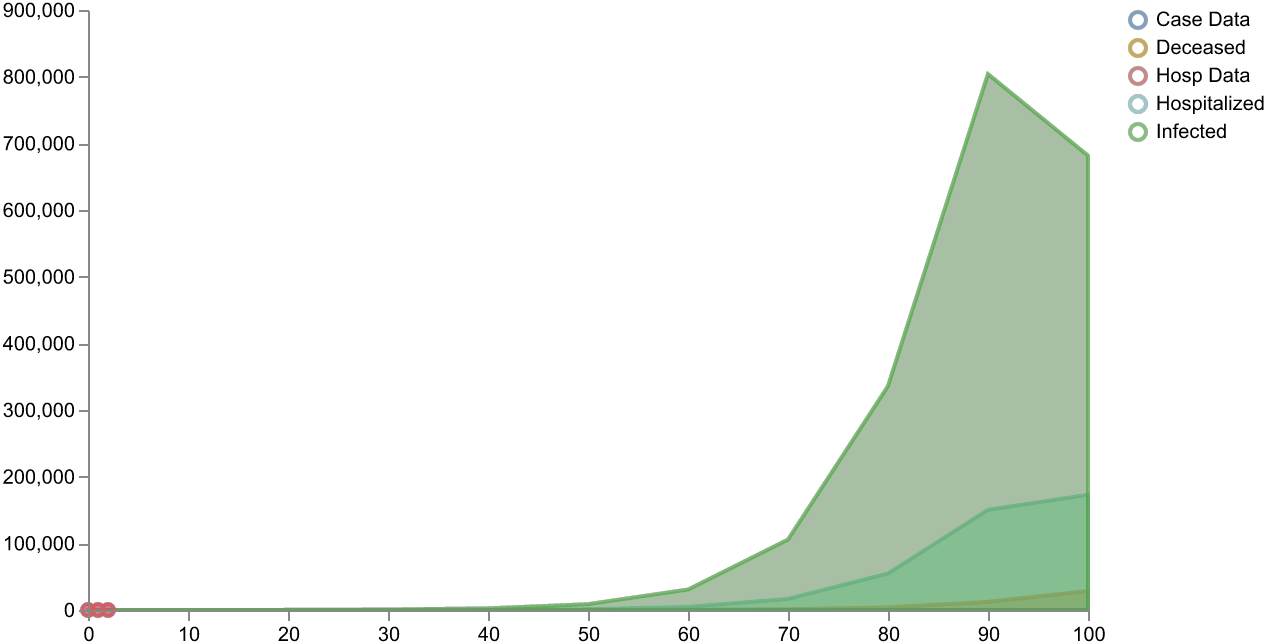

In [6]:
calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "dead_observable_state": "Deceased", 
        "hospitalized_observable_state": "Hospitalized",
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data",
        "hosp": "Hosp Data"
        }
data_df = pd.read_csv(dataset1)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state", "hospitalized_observable_state", "dead_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Shapley Values: How important were details *in the calibrated model*

In [7]:
import pyciemss.visuals.shapley as shapley
importlib.reload(shapley)


kappa_fn = shapley.discretized(n=5, center=parameter_estimates()["persistent_kappa"].item(), step=.001)
gamma_fn = shapley.discretized(n=5, center=parameter_estimates()["persistent_gamma"].item(), step=.001)
players = [("kappa", kappa_fn, "persistent_kappa_param"),
           ("gamma", gamma_fn, "persistent_gamma_param")]
payout = "hospitalized_observable_state"

observations = shapley.neyman_method(model1, 
                 parameter_estimates, 
                 players,
                 payout,
                 budget=5,
                 start_time=start_time,
                 end_time=end_time, 
                 logging_step_size=logging_step_size,
                 num_samples=num_samples,
                 )

Shapley sample 5: : 5.908689seconds [00:05,  1.00s/seconds]                


In [8]:
len(observations)

5

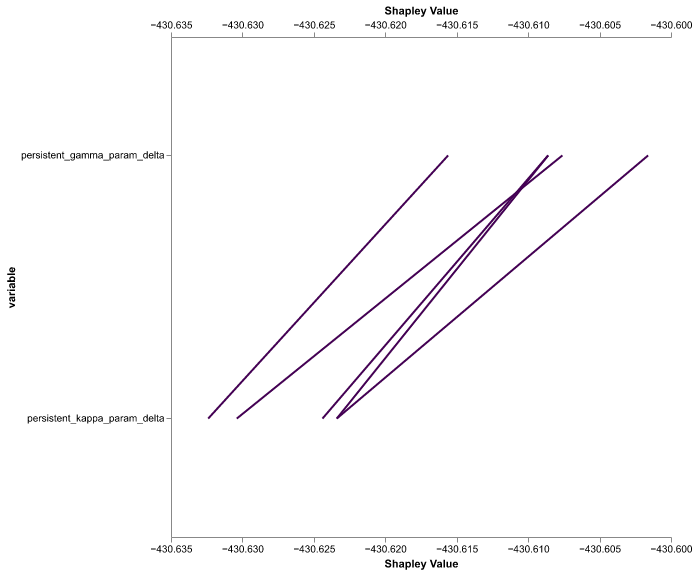

In [9]:
deltas = shapley.average_marginal_contribution(calibrated_sample_results["data"], observations, players, payout)
schema = shapley.shapley_decision_plot(deltas, players, payout)
plots.ipy_display(schema)

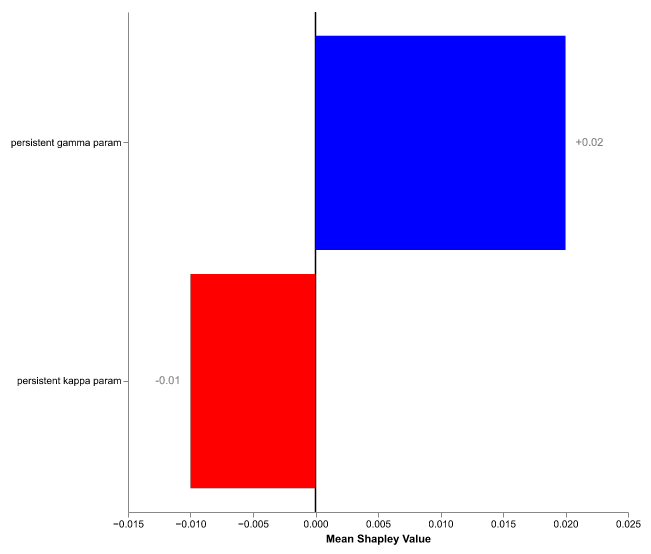

In [10]:
schema = shapley.shapley_bar_chart(deltas, players)
plots.ipy_display(schema)

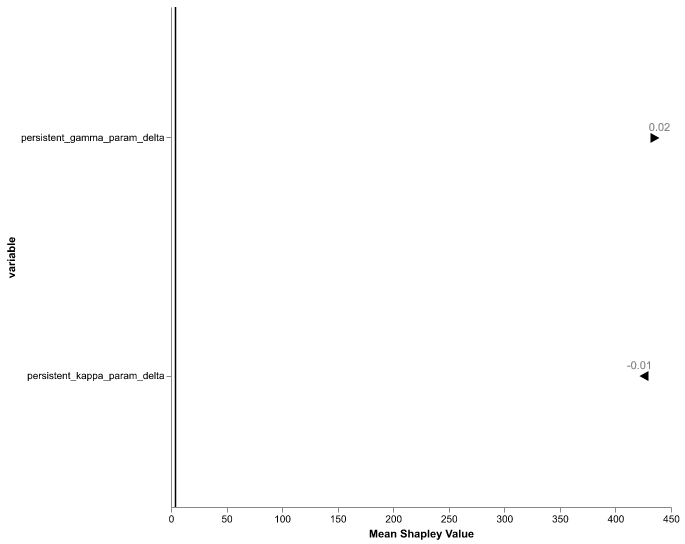

In [11]:
schema = shapley.shapley_waterfall(deltas, players, payout)
plots.ipy_display(schema)